This jupyter notebook loads and fits monoculture metabolite data. These data and fits are shown in Fig. 4 of the manuscript, and predictions based on these fits are shown in the supplementary information. 

First, load some modules and define a function to read metabolite data. 

In [1]:
import sys
sys.path.append('functions/')
import pandas as pd
import numpy as np
import griess as gr
import bmgdata as bd
import matplotlib.pyplot as plt
import glob
import denitfit as dn
import pickle
import copy

def load_plate_timeseries_no_OD(meta_fn,no2_fns,no2no3_540_fns,no2no3_900_fns,fit,pidx):
    plate_meta = pd.read_csv(meta_fn,index_col=0).dropna()  #import metadata and drop rows with any empty elements
    #reads in files and infers concentrations from absorbances using standard curve parameters ("fit")
    #assumes filenames are in the order t1, t2, t3, ...
    plate_no2 = pd.DataFrame()
    plate_no3 = pd.DataFrame()
    for i in range(0,len(no2_fns)):
        #print(no2_fns)
        no2 = gr.read_griess(meta_fn,data_fn=no2_fns[i])
        if no2no3_540_fns == None:
            no2no3 = None
        else:
            no2no3 = gr.read_griess(meta_fn,data_540_fn=no2no3_540_fns[i],data_900_fn=no2no3_900_fns[i])
        data = gr.invert_griess(no2,fit,no2no3)
        plate_no2 = plate_no2.append(data["NO2"].rename("t"+str(i+1)))
        plate_no3 = plate_no3.append(data["NO3"].rename("t"+str(i+1)))
    
    #adds a prefix to the column names to indicate what plate the sample belongs to
    plate_meta  = ((plate_meta.transpose()).add_prefix("p" + str(pidx) + "_")).transpose()
    plate_no2 = plate_no2.add_prefix("p" + str(pidx) + "_")
    plate_no3 = plate_no3.add_prefix("p" + str(pidx) + "_")
    
    #transposes data frame so columns are time points and rows are wells
    plate_no2 = plate_no2.transpose()
    plate_no3 = plate_no3.transpose()
    
    return [plate_meta,plate_no2,plate_no3]



Use known t=0 concentrations as standards to infer metabolite concentrations from absorbance measurements. 

(0.0, 4.0)

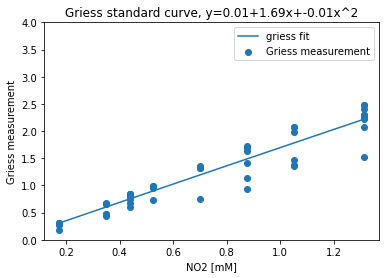

In [2]:
#fit griess assay model using standard curves based on sample at time 0 (i.e. prior to any microbial activity)
std_meta_fn = "data/standards_metadata_t0.csv"

std_no2_fn = glob.glob("data/KC_NO2_CRM_predict_cycle2_t1_20220620_1535_220623_130046.csv")[0]
std_no2no3_fn = None

std_no2no3_540_fn = glob.glob("data/CRM_predict_cycle2_t1_20220620_1535_Absorbance_KC_NO2NO3_540_SCAN.CSV")[0]
std_no2no3_900_fn = glob.glob("data/CRM_predict_cycle2_t1_20220620_1535_Absorbance_KC_NO2NO3_900_SCAN.CSV")[0]

fit = gr.fit_griess_mixed(std_meta_fn,std_no2_fn,no2no3_fn=std_no2no3_fn,no2no3_540_fn=std_no2no3_540_fn,no2no3_900_fn=std_no2no3_900_fn)
[[no2_blank_dont_use,no2no3_blank_dont_use], g_fit_dont_use, v_fit] = fit
gr.plot_griess_fit_mixed(std_meta_fn,std_no2_fn,no2no3_fn=std_no2no3_fn,no2no3_540_fn=std_no2no3_540_fn,no2no3_900_fn=std_no2no3_900_fn)
plt.ylim(0,4)

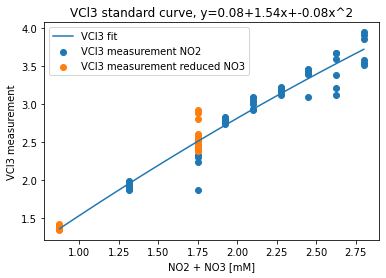

In [3]:
plt.cla()
gr.plot_vcl_fit_mixed(std_meta_fn,std_no2_fn,no2no3_fn=std_no2no3_fn,no2no3_540_fn=std_no2no3_540_fn,no2no3_900_fn=std_no2no3_900_fn)
plt.savefig('vcl3_standard_curve.png')

Load experimental data

In [4]:
#manually input time points for measurements (in units of hr)
t = np.array([15, 155, 309, 496, 654, 1010, 1711, 2695, 4132])/60.0 #for p and r, add 5-10 minutes for p+r

#Load plate 1 metabolite time series and endpoint OD
meta_fn = "data/plate1_metadata.csv"
no2_fns = sorted(glob.glob("data/*NO2_*CRM_predict_cycle2_*t*"))
no2no3_540_fns = sorted(glob.glob("data/*CRM_predict_*cycle2_*t*_*NO2NO3_540_SCAN.CSV"))
no2no3_900_fns = sorted(glob.glob("data/*CRM_predict_*cycle2_*t*_*NO2NO3_900_SCAN.CSV"))
[plate1_meta,plate1_no2,plate1_no3]=load_plate_timeseries_no_OD(meta_fn,no2_fns,no2no3_540_fns,no2no3_900_fns,fit,1)

#rename plate 1 info to be consistent with the rest of the code
merged_no2 = plate1_no2

merged_no3 = plate1_no3
merged_meta = plate1_meta

iterator = 0
for ID in merged_meta["isolate"]:
    iterator = iterator + 1
    
#use blanks to infer correction factor for evaporation
idx = (merged_meta["isolate"]=="blank")

merged_no3.loc[idx]
no3_2mM_corr = merged_no3.loc[idx].median().values[0]/merged_no3.loc[idx].median().values.reshape(-1,1)
no2_2mM_corr = merged_no2.loc[idx].median().values[0]/merged_no2.loc[idx].median().values.reshape(-1,1)

idx = (merged_meta["isolate"]=="blank") & (merged_meta["NO3_0"]==1)
no3_1mM_corr = merged_no3.loc[idx].median().values[0]/merged_no3.loc[idx].median().values.reshape(-1,1)
no2_1mM_corr = merged_no2.loc[idx].median().values[0]/merged_no2.loc[idx].median().values.reshape(-1,1)

idx = (merged_meta["isolate"]=="blank") & (merged_meta["NO3_0"]==2)
no3_mix_corr = merged_no3.loc[idx].median().values[0]/merged_no3.loc[idx].median().values.reshape(-1,1)
no2_mix_corr = merged_no2.loc[idx].median().values[0]/merged_no2.loc[idx].median().values.reshape(-1,1)

#apply correction factors to all wells
idx = (merged_meta["NO3_0"]<3) 

merged_no3.loc[idx] = merged_no3.loc[idx].multiply(np.transpose(no3_2mM_corr), axis='columns')
merged_no2.loc[idx] = merged_no2.loc[idx].multiply(np.transpose(no2_2mM_corr),axis='columns')


In [5]:
#get strain IDs
strain_IDs = np.setdiff1d(np.unique(merged_meta["genotype"]),['blank'])
all_experiments_10 = []

#define OD filename
OD_filename = 'data/KC_OD600_Greiner_CRM_predict_cycle2_OD_endpoint_220623_123059.csv'
OD_meta       = pd.read_csv(meta_fn,index_col=0).dropna(how='all')  #import metadata
OD_data_frame = bd.read_abs_endpoint(OD_filename)
OD_data_frame = OD_data_frame[OD_data_frame.index.isin(OD_meta.index)]

#dilution_factor = 8.0

#For each strain_ID, identify wells corresponding to each experimental condition and put into experiments object
for j in range(0,len(strain_IDs)):
    cond = np.array([[2,0,6],[1,0,6],[1,0.5,6],[0.5,1.5,6],[2,1.2,6],[2,1,6],[2,0.8,6],[2,0.6,6],[2,0.4,6],[2,0.2,6],[2,0,7.3],[1,0,7.3],[1,0.5,7.3],[0.5,1.5,7.3],[2,1.2,7.3],[2,1,7.3],[2,0.8,7.3],[2,0.6,7.3],[2,0.4,7.3],[2,0.2,7.3]])
    #load data into a list of experiment objects
    experiments = []
    for i in range(0,cond.shape[0]):
        blank_idx = (OD_meta["genotype"] == 'blank')
        blank_val = OD_data_frame[blank_idx].values
        OD_idx = ((OD_meta["genotype"]==strain_IDs[j]) & (OD_meta["NO3_0"]==cond[i,0]) & (OD_meta["NO2_0"]==cond[i,1]) & (OD_meta["pH"]==cond[i,2]))
        idx = ((merged_meta["genotype"]==strain_IDs[j]) & (merged_meta["NO3_0"]==cond[i,0]) & (merged_meta["NO2_0"]==cond[i,1])& (merged_meta["pH"]==cond[i,2]))
        #print(idx)
        ID = strain_IDs[j]
        A0 = cond[i,0]
        A = merged_no3.loc[idx].values
        I0 = cond[i,1]
        I = merged_no2.loc[idx].values
        pH = cond[i,2]
        N0 = (0.04/8.0) 
        Nend = OD_data_frame[OD_idx].values - np.mean(blank_val) 
        phen = 'Nar/Nir'
        succ_conc = 4
        experiments.append(dn.enrichment_experiment(ID, phen, N0, Nend, A0, A, I0, I, t, succ_conc, pH, endpoint_pH = None))
    all_experiments_10.append(experiments)
pickle_out = open("CRM_predict_cycle2_experiments.pkl","wb")
pickle.dump(all_experiments_10, pickle_out)
pickle_out.close()

First, plot raw metabolite dynamics at pH 6

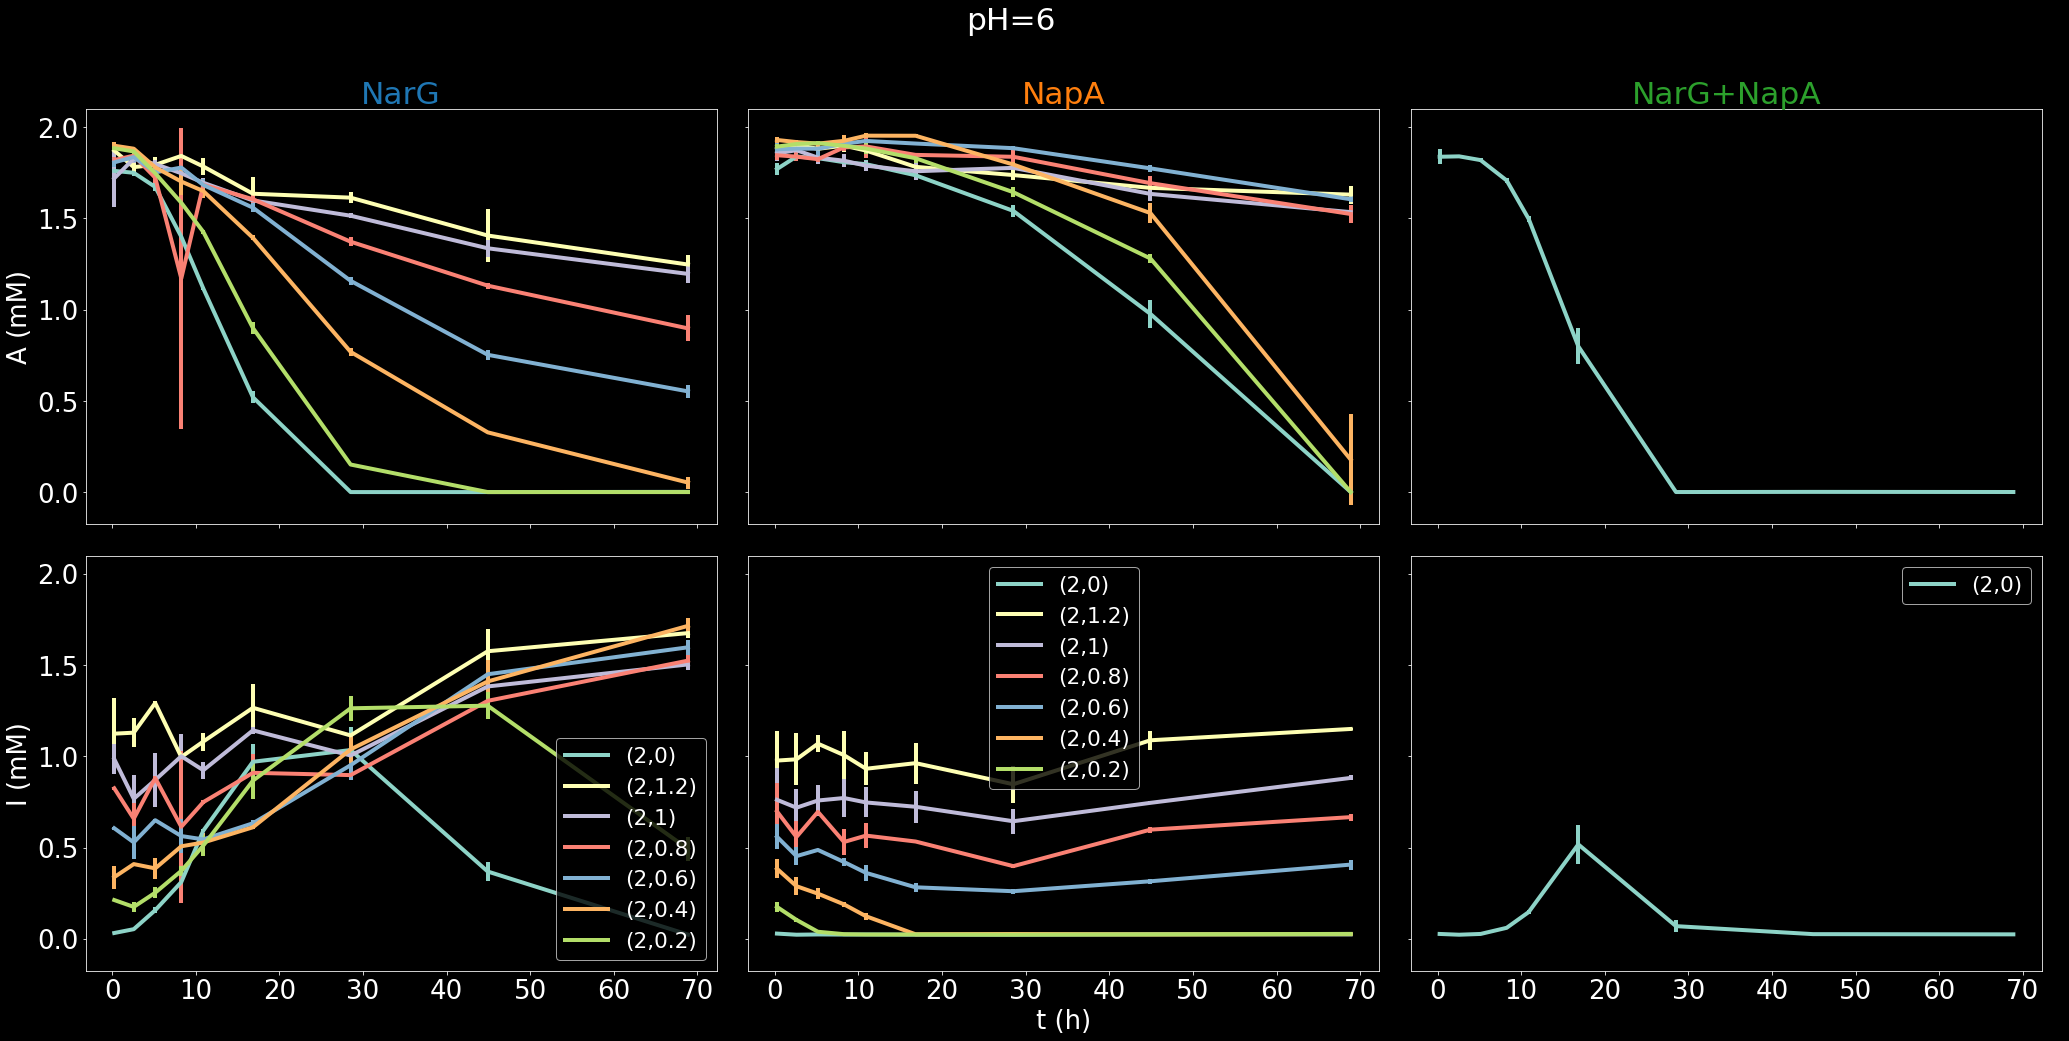

In [6]:
#######################################################################################
##################### pH 6 scan across initial nitrite values #########################
#######################################################################################

from pprint import pprint
#strain_str = '6-1-12-14'
strain_strs = ['NarG', 'NapA', 'NarG+NapA']
colors = ['tab:blue', 'tab:orange', 'tab:green']
NO2_conc = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.5]

A = 2
plt.style.use('dark_background')
plt.rcParams.update({"text.usetex": False, 'font.size': 26})
linewidth = 4.0
alpha = 1
fig, axs = plt.subplots(2,3,figsize=(30,15), sharex = True, sharey = True)
fig.tight_layout()
pH = 6
col_idx = 0
for strain_str in strain_strs:

    for experiments in all_experiments_10:
        for experiment in experiments:
            iterator = 0
            for I in NO2_conc:
                if experiment.pH == pH and experiment.ID == strain_str and experiment.I0 == I and experiment.A0 == A:
                    if len(experiment.A) > 0:
                        p = axs[0][col_idx].plot(experiment.t, np.mean(experiment.A, axis = 0), label = '('+str(A)+','+str(I)+')', alpha = alpha, linewidth = linewidth)
                        color = p[0].get_color()
                        axs[0][col_idx].vlines(experiment.t, np.mean(experiment.A, axis = 0) - np.std(experiment.A, axis = 0),np.mean(experiment.A, axis = 0) + np.std(experiment.A, axis = 0), color = color, linewidth = linewidth, alpha = alpha)

                        axs[0][col_idx].set_title(strain_str, color = colors[col_idx])
                        axs[1][col_idx].plot(experiment.t, np.mean(experiment.I, axis = 0), color = color, label = '('+str(A)+','+str(I)+')', alpha = alpha, linewidth = linewidth)
                        axs[1][col_idx].vlines(experiment.t, np.mean(experiment.I, axis = 0) - np.std(experiment.I, axis = 0),np.mean(experiment.I, axis = 0) + np.std(experiment.I, axis = 0), color = color, alpha = alpha, linewidth = linewidth)
                        axs[1][col_idx].legend(prop = {'size':'small'})

                iterator = iterator+1
    col_idx = col_idx+1

axs[0][0].set_ylabel('A (mM)')
axs[1][0].set_ylabel('I (mM)')
plt.suptitle('pH='+str(pH))
fig.tight_layout()
fig.add_subplot(111, frameon=False)
fig.tight_layout()

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("t (h)", fontsize = 26)
plt.show()

No handles with labels found to put in legend.


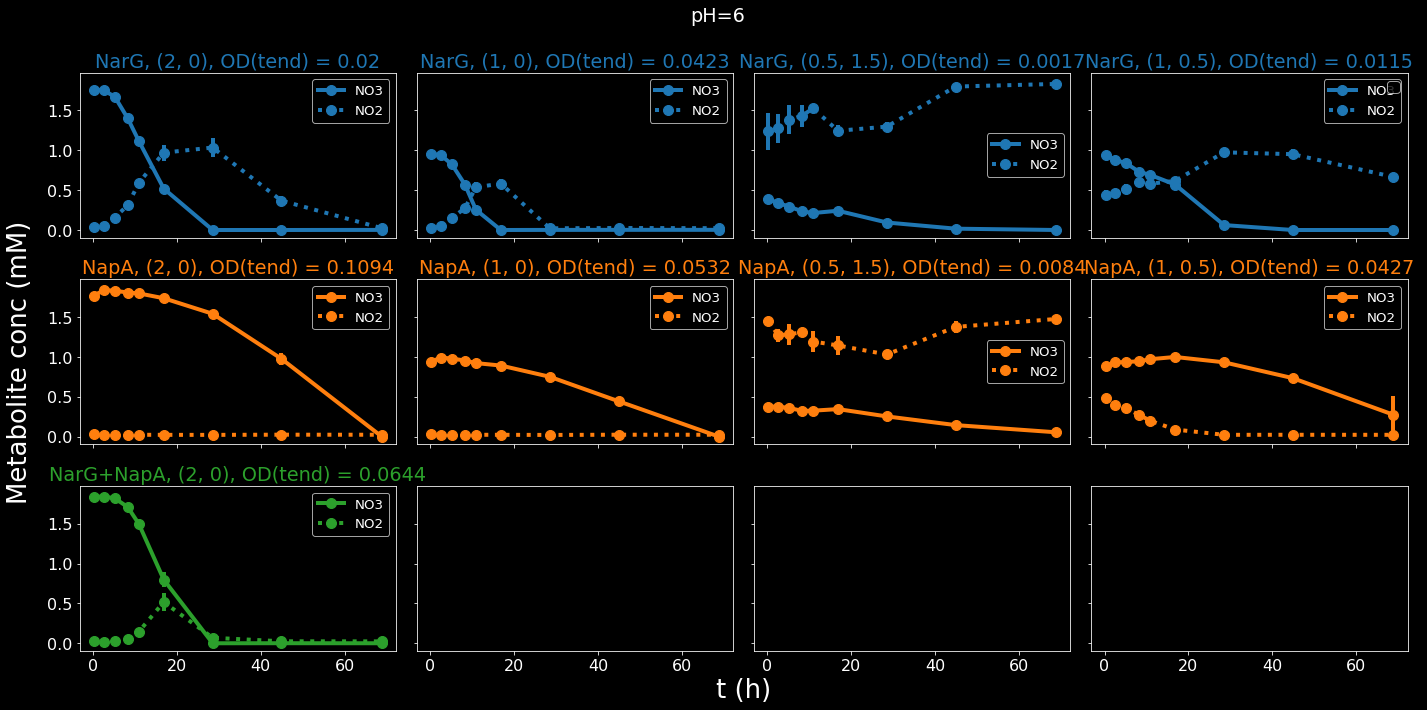

In [7]:
#######################################################################################
##################### pH 6 (attempted) fitting conditions #########################
#######################################################################################

#note that high-nitrite conditions inhibit growth, making fit impossible


from pprint import pprint
#strain_str = '6-1-12-14'
strain_strs = ['NarG', 'NapA', 'NarG+NapA']
colors = ['tab:blue', 'tab:orange', 'tab:green']
conditions = [[2,0], [1,0], [0.5, 1.5], [1, 0.5]]
#NO2_conc = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]

pH = 6
plt.style.use('dark_background')
plt.rcParams.update({"text.usetex": False, 'font.size': 16})
fig, axs = plt.subplots(3,4,figsize=(20,10), sharex = True, sharey = True)
fig.tight_layout()
markersize = 10.0
#pH_vals = [6.0]
col_idx = 0
for strain_str in strain_strs:
    for iterator in range(0,4):
        for experiments in all_experiments_10:
            for experiment in experiments:
                if experiment.pH == pH and experiment.ID == strain_str and experiment.I0 == conditions[iterator][1] and experiment.A0 == conditions[iterator][0]:
                    #pprint(vars(experiment))
                    if len(experiment.A) > 0:
                        A = conditions[iterator][0]
                        I = conditions[iterator][1]
                        color = colors[col_idx]                      
                        axs[col_idx][iterator].plot(experiment.t, np.mean(experiment.A, axis = 0), '-o', label = 'NO3', markersize= markersize, alpha = alpha, color = color,  linewidth = linewidth)
                        
                        axs[col_idx][iterator].vlines(experiment.t, np.mean(experiment.A, axis = 0) - np.std(experiment.A, axis = 0),np.mean(experiment.A, axis = 0) + np.std(experiment.A, axis = 0), color = color, linewidth = linewidth, alpha = alpha)

                        #axs[col_idx][iterator].set_title(strain_str+', ('+str(A)+', '+str(I)+'), \dOD = '+str(round(np.mean(experiment.Nend - experiment.N0),2))+', OD(tend) = '+str(round(np.mean(experiment.Nend),3)), color = colors[col_idx])
                        axs[col_idx][iterator].set_title(strain_str+', ('+str(A)+', '+str(I)+'), OD(tend) = '+str(round(np.mean(experiment.Nend),4)), color = colors[col_idx])
                        #axs[0][col_idx].legend()
                        #pprint(vars(experiment))
                        
                        axs[col_idx][iterator].plot(experiment.t, np.mean(experiment.I, axis = 0), ':o', markersize= markersize, color = color, label = 'NO2', alpha = alpha, linewidth = linewidth)
                        axs[col_idx][iterator].vlines(experiment.t, np.mean(experiment.I, axis = 0) - np.std(experiment.I, axis = 0),np.mean(experiment.I, axis = 0) + np.std(experiment.I, axis = 0), color = color, alpha = alpha, linewidth = linewidth)
                        axs[col_idx][iterator].legend(prop = {'size':'small'})


    col_idx = col_idx+1
plt.suptitle('pH='+str(pH))
fig.add_subplot(111, frameon=False)
fig.tight_layout()
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)


plt.xlabel("t (h)", fontsize = 26)
plt.ylabel(r"Metabolite conc (mM)", fontsize = 26)
plt.ylim([0,2.2])
plt.legend()
plt.show()



Compare dynamics across strain at each pH and metabolite condition

No handles with labels found to put in legend.


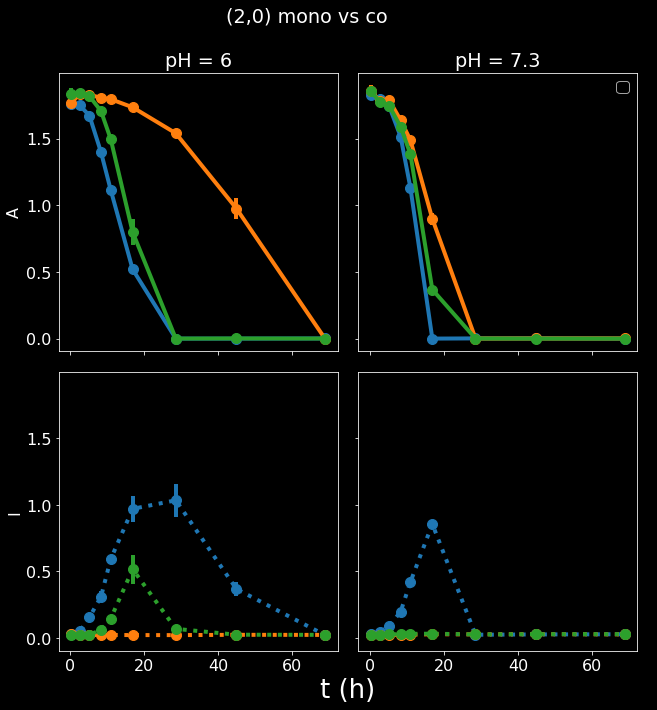

In [8]:
from pprint import pprint
#strain_str = '6-1-12-14'
strain_strs = ['NarG', 'NapA', 'NarG+NapA']
colors = ['tab:blue', 'tab:orange', 'tab:green']

#NO2_conc = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]

pHs = [6, 7.3]
plt.style.use('dark_background')
plt.rcParams.update({"text.usetex": False, 'font.size': 16})
fig, axs = plt.subplots(2,2,figsize=(10,10), sharex = True, sharey = True)
fig.tight_layout()
markersize = 10.0
#pH_vals = [6.0]
iterator = 0
for strain_str in strain_strs:
    for i in range(len(pHs)):
        for experiments in all_experiments_10:
            for experiment in experiments:
                if experiment.pH == pHs[i] and experiment.ID == strain_str and experiment.I0 == 0 and experiment.A0 == 2:
                    #pprint(vars(experiment))
                    if len(experiment.A) > 0:
                        color = colors[iterator]                      
                        axs[0][i].plot(experiment.t, np.mean(experiment.A, axis = 0), '-o', label = 'NO3', markersize= markersize, alpha = alpha, color = color,  linewidth = linewidth)
                        
                        axs[0][i].vlines(experiment.t, np.mean(experiment.A, axis = 0) - np.std(experiment.A, axis = 0),np.mean(experiment.A, axis = 0) + np.std(experiment.A, axis = 0), color = color, linewidth = linewidth, alpha = alpha)

                        axs[0][i].set_title('pH = '+str(pHs[i]))#, color = colors[col_idx])
                        
                        #axs[0][col_idx].legend()
                        #pprint(vars(experiment))
                        
                        axs[1][i].plot(experiment.t, np.mean(experiment.I, axis = 0), ':o', markersize= markersize, color = color, label = 'NO2', alpha = alpha, linewidth = linewidth)
                        axs[1][i].vlines(experiment.t, np.mean(experiment.I, axis = 0) - np.std(experiment.I, axis = 0),np.mean(experiment.I, axis = 0) + np.std(experiment.I, axis = 0), color = color, alpha = alpha, linewidth = linewidth)
                        
                        #axs[0][i].legend(prop = {'size':'small'})
    iterator = iterator+1

axs[0][0].set_ylabel('A')
axs[1][0].set_ylabel('I')
plt.suptitle('(2,0) mono vs co')
fig.add_subplot(111, frameon=False)
fig.tight_layout()
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)


#plt.title(strain_str+', (A0,I0)=(' + str(NO3_conc)+','+str(NO2_conc)+')')

plt.xlabel("t (h)", fontsize = 26)
#plt.ylabel(r"Metabolite conc (mM)", fontsize = 26)
plt.ylim([0,2.2])
plt.legend()
plt.show()




Having examined the data, now attempt to fit. 

In [9]:
### First, fit pH 7.3 PD Nar+ data ###
from lmfit import Parameters, report_fit, Minimizer, conf_interval
import nitrite_toxicity_model as ntm  #we will use a general model that can in principle account for nitrite toxicity, but we will choose parameters such that nitrite has no toxic effect

pH = 7.3
experiments_to_fit = []
strain_to_fit = 'NarG'
for experiments in all_experiments_10:
        for experiment in experiments:
                if experiment.pH == pH and experiment.ID == strain_to_fit:  #load all pH 7.3 and PD Nar+ experiments                                                                                                                                                           
                        experiments_to_fit.append(experiment)                                                                                                                          
                        t_vals = experiment.t

                        for A_rep in experiment.A:                                                                                                             
                                A_vals = np.asarray(A_rep)                                                                                                                        
                        for I_rep in experiment.I:                                                                                                             
                                I_vals = np.asarray(I_rep)                                                                                                                     

#now fit
pfit, chisqr_val, best_result_params, gamA_std_7_NarG, gamI_std_7_NarG =  dn.fit_met(experiments_to_fit)#, gamA = gamA_7_NapA, gamI = gamI_7_NapA)
gamA_7_NarG = best_result_params['gamA'].value
gamI_7_NarG = best_result_params['gamI'].value

pfit_NarG = pfit #rename for later plotting

#save fit data
np.savez('fits/NarG_fit_pH='+str(pH)+'_no_offset',rA = best_result_params['rA'].value,\
         rA_std = best_result_params['rA'].stderr,  rI = best_result_params['rI'].value,\
         rI_std = best_result_params['rI'].stderr, gamA = best_result_params['gamA'].value,\
         gamA_std =gamA_std_7_NarG,  gamI = best_result_params['gamI'].value,\
         gamI_std =gamI_std_7_NarG,  pfit = pfit,  chisqr_val = chisqr_val)


/home/kyle/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [10]:
### now fit RH Nap+ pH 7.3 in the same way ###

pH = 7.3
experiments_to_fit = []
strain_to_fit = 'NapA'
for experiments in all_experiments_10:
        for experiment in experiments:
                if experiment.pH == pH and experiment.ID == strain_to_fit:                                                                                                                                                                
                        experiments_to_fit.append(experiment)                                                                                                                         
                        t_vals = experiment.t

                        for A_rep in experiment.A:                                                                                                             
                                A_vals = np.asarray(A_rep)                                                                                                                        
                        for I_rep in experiment.I:                                                                                                             
                                I_vals = np.asarray(I_rep)                                                                                                                       

pfit, chisqr_val, best_result_params, gamA_std_7_NapA, gamI_std_7_NapA =  dn.fit_met(experiments_to_fit)#, gamA = gamA_7_NapA, gamI = gamI_7_NapA)
gamA_7_NapA = best_result_params['gamA'].value
gamI_7_NapA = best_result_params['gamI'].value


pfit_NapA = pfit
np.savez('fits/NapA_fit_pH='+str(pH)+'_no_offset',rA = best_result_params['rA'].value,\
         rA_std = best_result_params['rA'].stderr,  rI = best_result_params['rI'].value,\
         rI_std = best_result_params['rI'].stderr, gamA = best_result_params['gamA'].value,\
         gamA_std =gamA_std_7_NapA,  gamI = best_result_params['gamI'].value,\
         gamI_std =gamI_std_7_NapA,  pfit = pfit,  chisqr_val = chisqr_val)



/home/kyle/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


No handles with labels found to put in legend.


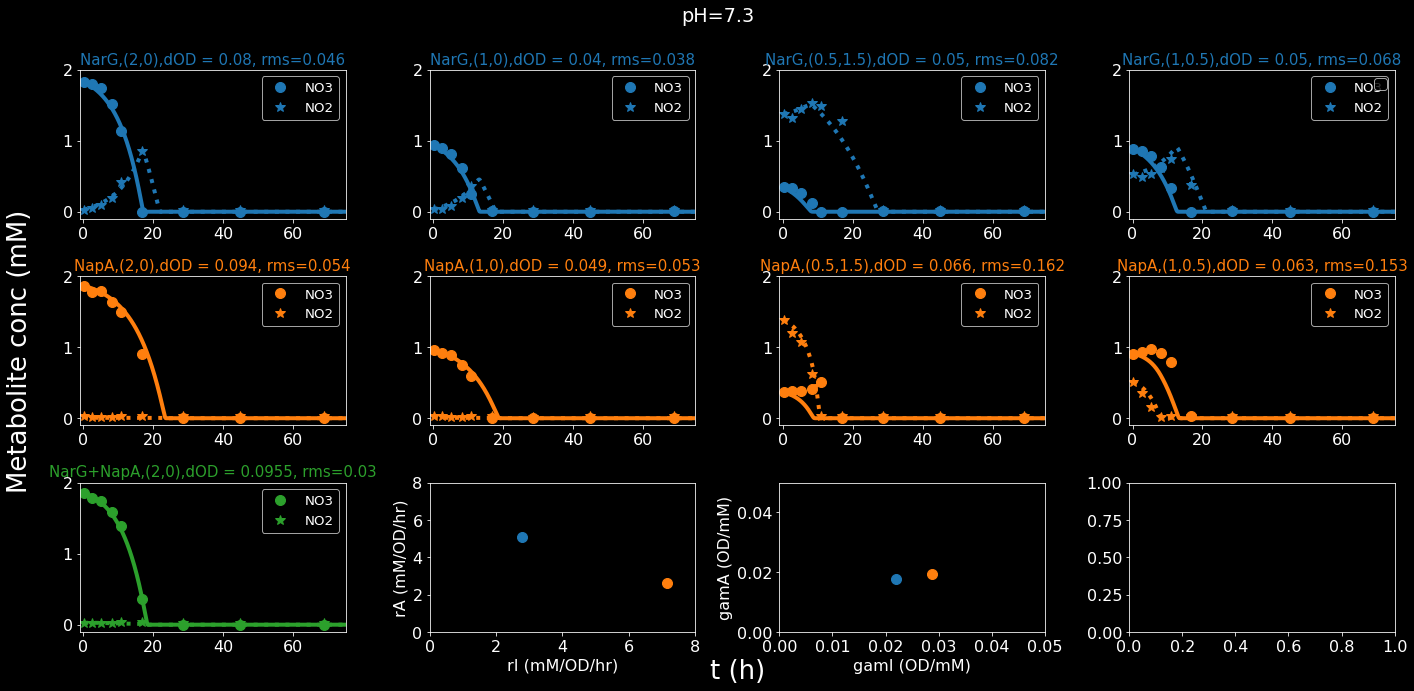

In [11]:
#finally, plot our pH 7.3 fits. they look good!


strain_strs = ['NarG', 'NapA', 'NarG+NapA']
colors = ['tab:blue', 'tab:orange', 'tab:green']
conditions = [[2,0], [1,0], [0.5, 1.5], [1, 0.5]]


plt.style.use('dark_background')
plt.rcParams.update({"text.usetex": False, 'font.size': 16})
fig, axs = plt.subplots(3,4,figsize=(20,10), sharex = False, sharey = False)
fig.tight_layout()
markersize = 10.0
col_idx = 0
for strain_str in strain_strs:
    for iterator in range(0,4):
        for experiments in all_experiments_10:
            for experiment in experiments:
                if experiment.pH == pH and experiment.ID == strain_str and experiment.I0 == conditions[iterator][1] and experiment.A0 == conditions[iterator][0]:
                    if len(experiment.A) > 0:
                        A = conditions[iterator][0]
                        I = conditions[iterator][1]
                        color = colors[col_idx]                      
                        axs[col_idx][iterator].plot(experiment.t, np.mean(experiment.A, axis = 0), 'o', label = 'NO3', markersize= markersize, alpha = alpha, color = color,  linewidth = linewidth)
                        
                        axs[col_idx][iterator].vlines(experiment.t, np.mean(experiment.A, axis = 0) - np.std(experiment.A, axis = 0),np.mean(experiment.A, axis = 0) + np.std(experiment.A, axis = 0), color = color, linewidth = linewidth, alpha = alpha)
                        
                        ts = np.linspace(0,75, 1000)
                        if experiment.ID == 'NarG':
                            y0 = [experiment.N0, 0, np.mean(experiment.A, axis = 0)[0], np.mean(experiment.I, axis = 0)[0]]

                            yh = ntm.denitODE(y0,ts,pfit_NarG,1)
                            N_1 = yh[:,0]                                                                                                                                                                            \

                            N_1_dead = yh[:,1]

                            A_vals = yh[:,2]
                            I_vals = yh[:,3]

                            axs[col_idx][iterator].plot(ts+experiment.t[0], A_vals, linewidth = linewidth, color = 'tab:blue', alpha = alpha)#, label = 'mono fit pred.')

                            axs[col_idx][iterator].plot(ts+experiment.t[0], I_vals,':', linewidth = linewidth, color = 'tab:blue', alpha = alpha)#, label = 'mono fit pred.')
                            square = 0
                            num_vals = 0
                            for i in range(len(experiment.t)):
                                t_idx = np.argmin(np.abs(ts + experiment.t[0] - experiment.t[i]))
                                for j in range(len(experiment.A[:,i])):
                                    square = square + (experiment.A[j,i] - A_vals[t_idx])**2
                                    square = square + (experiment.I[j,i] - I_vals[t_idx])**2
                                    num_vals = num_vals + 2
                            mean = square / num_vals
                            rms = np.sqrt(mean)
                            axs[col_idx][iterator].set_title(strain_str+',('+str(A)+','+str(I)+'),dOD = '+str(round(np.mean(experiment.Nend - experiment.N0),2))+', rms='+str(round(rms,3)), color = colors[col_idx], fontsize = 15.0)
    
                            
                        elif experiment.ID == 'NapA':                 
                            y0 = [experiment.N0, 0, np.mean(experiment.A, axis = 0)[0], np.mean(experiment.I, axis = 0)[0]]

                            yh = ntm.denitODE(y0,ts,pfit_NapA,1)
                            N_1 = yh[:,0]                                                                                                                                                                            \

                            N_1_dead = yh[:,1]

                            A_vals = yh[:,2]
                            I_vals = yh[:,3]

                            axs[col_idx][iterator].plot(ts+experiment.t[0], A_vals, linewidth = linewidth, color = 'tab:orange', alpha = alpha)#, label = 'mono fit pred.')

                            axs[col_idx][iterator].plot(ts+experiment.t[0], I_vals,':', linewidth = linewidth, color = 'tab:orange', alpha = alpha)#, label = 'mono fit pred.')

                            square = 0
                            num_vals = 0
                            for i in range(len(experiment.t)):
                                t_idx = np.argmin(np.abs(ts + experiment.t[0] - experiment.t[i]))
                                for j in range(len(experiment.A[:,i])):
                                    square = square + (experiment.A[j,i] - A_vals[t_idx])**2
                                    square = square + (experiment.I[j,i] - I_vals[t_idx])**2
                                    num_vals = num_vals + 2
                            mean = square / num_vals
                            rms = np.sqrt(mean)
                            axs[col_idx][iterator].set_title(strain_str+',('+str(A)+','+str(I)+'),dOD = '+str(round(np.mean(experiment.Nend - experiment.N0),3))+', rms='+str(round(rms,3)), color = colors[col_idx], fontsize = 15.0)

                        
                        
                        else:
                            y0 = [experiment.N0/2.0, 0,experiment.N0/2.0, 0, np.mean(experiment.A, axis = 0)[0], np.mean(experiment.I, axis = 0)[0]]

                            yh = ntm.denitODE(y0,ts,[pfit_NarG,pfit_NapA],2)
                            N_1 = yh[:,0]                                                                                                                                                                            \

                            N_1_dead = yh[:,1]

                            A_vals = yh[:,4]
                            I_vals = yh[:,5]

                            axs[col_idx][iterator].plot(ts+experiment.t[0], A_vals, linewidth = linewidth, color = 'tab:green', alpha = alpha)#, label = 'mono fit pred.')

                            axs[col_idx][iterator].plot(ts+experiment.t[0], I_vals,':', linewidth = linewidth, color = 'tab:green', alpha = alpha)#, label = 'mono fit pred.')

                            square = 0
                            num_vals = 0
                            for i in range(len(experiment.t)):
                                t_idx = np.argmin(np.abs(ts + experiment.t[0] - experiment.t[i]))
                                for j in range(len(experiment.A[:,i])):
                                    square = square + (experiment.A[j,i] - A_vals[t_idx])**2
                                    square = square + (experiment.I[j,i] - I_vals[t_idx])**2
                                    num_vals = num_vals + 2
                            mean = square / num_vals
                            rms = np.sqrt(mean)
                            axs[col_idx][iterator].set_title(strain_str+',('+str(A)+','+str(I)+'),dOD = '+str(round(np.mean(experiment.Nend - experiment.N0),4))+', rms='+str(round(rms,2)), color = colors[col_idx], fontsize = 15.0)

                        axs[col_idx][iterator].plot(experiment.t, np.mean(experiment.I, axis = 0), '*', markersize= markersize, color = color, label = 'NO2', alpha = alpha, linewidth = linewidth)
                        axs[col_idx][iterator].vlines(experiment.t, np.mean(experiment.I, axis = 0) - np.std(experiment.I, axis = 0),np.mean(experiment.I, axis = 0) + np.std(experiment.I, axis = 0), color = color, alpha = alpha, linewidth = linewidth)
                        axs[col_idx][iterator].legend(prop = {'size':'small'})
                        axs[col_idx][iterator].set_ylim([-0.1, 2])
                        axs[col_idx][iterator].set_xlim([-1, 75])


    col_idx = col_idx+1
axs[2][1].plot(pfit_NarG[1], pfit_NarG[0], 'o', color = 'tab:blue', markersize = markersize)
axs[2][1].plot(pfit_NapA[1], pfit_NapA[0], 'o', color = 'tab:orange', markersize = markersize)
axs[2][1].set_ylabel('rA (mM/OD/hr)')
axs[2][1].set_xlabel('rI (mM/OD/hr)')
axs[2][1].set_xlim([0,8])
axs[2][1].set_ylim([0,8])


axs[2][2].plot(pfit_NarG[5], pfit_NarG[4], 'o', color = 'tab:blue', markersize = markersize)
axs[2][2].plot(pfit_NapA[5], pfit_NapA[4], 'o', color = 'tab:orange', markersize = markersize)
axs[2][2].set_ylabel('gamA (OD/mM)')
axs[2][2].set_xlabel('gamI (OD/mM)')
axs[2][2].set_xlim([0,0.05])
axs[2][2].set_ylim([0,0.05])

plt.suptitle('pH='+str(pH))
fig.add_subplot(111, frameon=False)
fig.tight_layout()
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)


plt.xlabel("t (h)", fontsize = 26)
plt.ylabel(r"Metabolite conc (mM)", fontsize = 26)
plt.ylim([0,2.2])
plt.legend()
plt.show()



In [12]:
### now fit PD Nar+ pH 6 ###

pH = 6
experiments_to_fit = []
strain_to_fit = 'NarG'
for experiments in all_experiments_10:
        for experiment in experiments:
                #to avoid nitrite toxicity, only fit (A,I) = (2,0) initial condition 
                if experiment.pH == pH and experiment.ID == strain_to_fit and experiment.A0 == 1 and experiment.I0 == 0:                                                                                                                                                                                                  
                        experiments_to_fit.append(experiment)                                                                                                                          
                        t_vals = experiment.t

                        for A_rep in experiment.A:                                                                                                             
                                A_vals = np.asarray(A_rep)                                                                                                                       
                        for I_rep in experiment.I:                                                                                                             
                                I_vals = np.asarray(I_rep)                                                                                                                       

#due to nitrite toxicity, use pH 7.3 yield parameters
pfit, chisqr_val, best_result_params, gamA_std_7_NarG, gamI_std_7_NarG =  dn.fit_met(experiments_to_fit, gamA = gamA_7_NarG, gamI = gamI_7_NarG, gamA_std = gamA_std_7_NarG, gamI_std = gamI_std_7_NarG)
gamA_7_NarG = best_result_params['gamA'].value
gamI_7_NarG = best_result_params['gamI'].value

pfit_NarG = pfit
np.savez('fits/NarG_fit_pH='+str(pH)+'_no_offset_pH7_yields',rA = best_result_params['rA'].value,\
         rA_std = best_result_params['rA'].stderr,  rI = best_result_params['rI'].value,\
         rI_std = best_result_params['rI'].stderr, gamA = best_result_params['gamA'].value,\
         gamA_std =gamA_std_7_NarG,  gamI = best_result_params['gamI'].value,\
         gamI_std =gamI_std_7_NarG,  pfit = pfit,  chisqr_val = chisqr_val)



In [13]:
### now fit RH Nap+ pH 6 data ###

pH = 6
experiments_to_fit = []
strain_to_fit = 'NapA'
for experiments in all_experiments_10:
        for experiment in experiments:
                #fit only low nitrite conditions to minimize effect of toxicity
                if experiment.pH == pH and experiment.ID == strain_to_fit and experiment.I0 < 0.55:                                                                                                                                                       
                        experiments_to_fit.append(experiment)                                                                                                                         
                        t_vals = experiment.t

                        for A_rep in experiment.A:                                                                                                             
                                A_vals = np.asarray(A_rep)                                                                                                                     
                        for I_rep in experiment.I:                                                                                                              
                                I_vals = np.asarray(I_rep)                                                                                                                       

#due to nitrite toxicity, use pH 7.3 yield estimates
pfit, chisqr_val, best_result_params, gamA_std_7_NapA, gamI_std_7_NapA =  dn.fit_met(experiments_to_fit, gamA = gamA_7_NapA, gamI = gamI_7_NapA, gamA_std = gamA_std_7_NapA, gamI_std = gamI_std_7_NapA)
gamA_7_NapA = best_result_params['gamA'].value
gamI_7_NapA = best_result_params['gamI'].value

pfit_NapA = pfit
np.savez('fits/NapA_fit_pH='+str(pH)+'_no_offset',rA = best_result_params['rA'].value,\
         rA_std = best_result_params['rA'].stderr,  rI = best_result_params['rI'].value,\
         rI_std = best_result_params['rI'].stderr, gamA = best_result_params['gamA'].value,\
         gamA_std =gamA_std_7_NapA,  gamI = best_result_params['gamI'].value,\
         gamI_std =gamI_std_7_NapA,  pfit = pfit,  chisqr_val = chisqr_val)

No handles with labels found to put in legend.


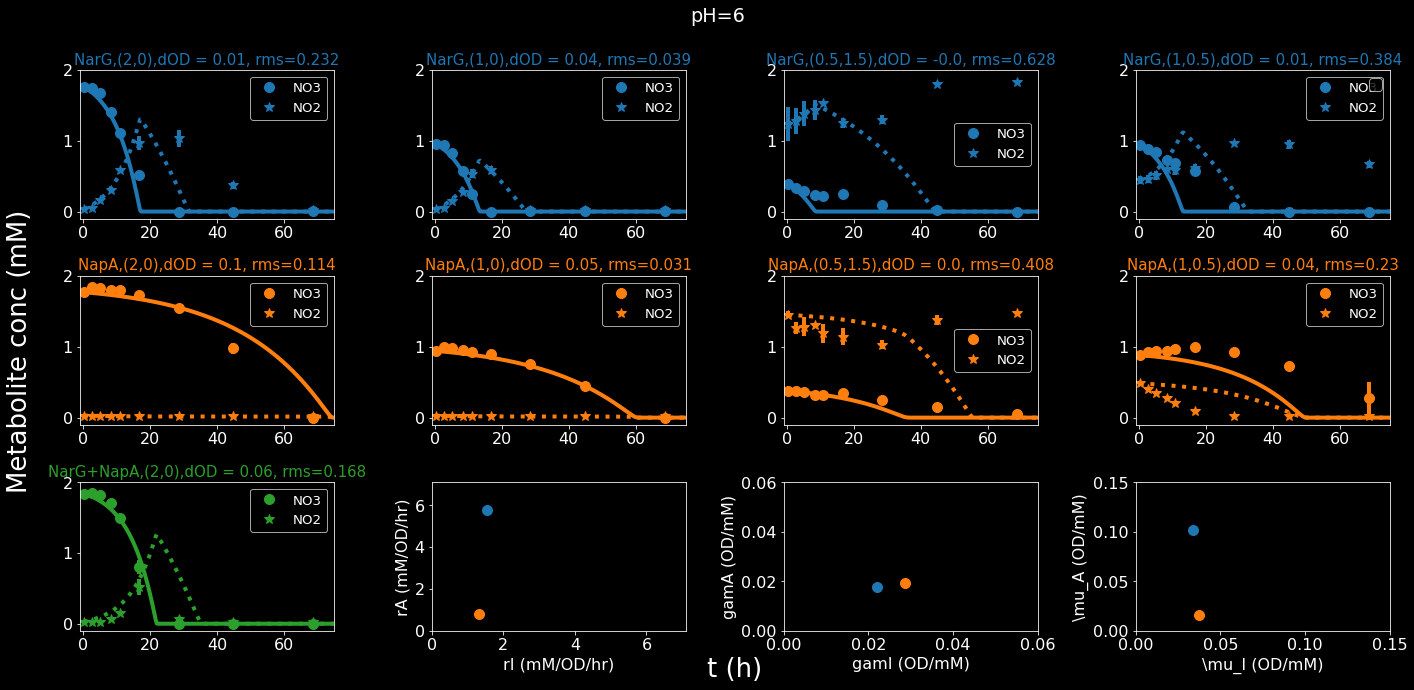

In [14]:
## plot pH 6 fits. note that since this model does not account for nitrite toxicity, fits break down in the presence of high nitrite concentrations ###

strain_strs = ['NarG', 'NapA', 'NarG+NapA']
colors = ['tab:blue', 'tab:orange', 'tab:green']
conditions = [[2,0], [1,0], [0.5, 1.5], [1, 0.5]]

plt.style.use('dark_background')
plt.rcParams.update({"text.usetex": False, 'font.size': 16})
fig, axs = plt.subplots(3,4,figsize=(20,10), sharex = False, sharey = False)
fig.tight_layout()
markersize = 10.0
col_idx = 0
for strain_str in strain_strs:
    for iterator in range(0,4):
        for experiments in all_experiments_10:
            for experiment in experiments:
                if experiment.pH == pH and experiment.ID == strain_str and experiment.I0 == conditions[iterator][1] and experiment.A0 == conditions[iterator][0]:
                    
                    if len(experiment.A) > 0:
                        A = conditions[iterator][0]
                        I = conditions[iterator][1]
                        color = colors[col_idx]                      
                        axs[col_idx][iterator].plot(experiment.t, np.mean(experiment.A, axis = 0), 'o', label = 'NO3', markersize= markersize, alpha = alpha, color = color,  linewidth = linewidth)
                        
                        axs[col_idx][iterator].vlines(experiment.t, np.mean(experiment.A, axis = 0) - np.std(experiment.A, axis = 0),np.mean(experiment.A, axis = 0) + np.std(experiment.A, axis = 0), color = color, linewidth = linewidth, alpha = alpha)
                        
                        ts = np.linspace(0,75, 256)
                        if experiment.ID == 'NarG':
                            y0 = [experiment.N0, 0, np.mean(experiment.A, axis = 0)[0], np.mean(experiment.I, axis = 0)[0]]

                            yh = ntm.denitODE(y0,ts,pfit_NarG,1)
                            N_1 = yh[:,0]                                                                                                                                                                            \

                            N_1_dead = yh[:,1]

                            A_vals = yh[:,2]
                            I_vals = yh[:,3]

                            axs[col_idx][iterator].plot(ts+experiment.t[0], A_vals, linewidth = linewidth, color = 'tab:blue', alpha = alpha)#, label = 'mono fit pred.')

                            axs[col_idx][iterator].plot(ts+experiment.t[0], I_vals,':', linewidth = linewidth, color = 'tab:blue', alpha = alpha)#, label = 'mono fit pred.')
 
                            square = 0
                            num_vals = 0
                            for i in range(len(experiment.t)):
                                t_idx = np.argmin(np.abs(ts + experiment.t[0] - experiment.t[i]))
                                for j in range(len(experiment.A[:,i])):
                                    square = square + (experiment.A[j,i] - A_vals[t_idx])**2
                                    square = square + (experiment.I[j,i] - I_vals[t_idx])**2
                                    num_vals = num_vals + 2
                            mean = square / num_vals
                            rms = np.sqrt(mean)
                            axs[col_idx][iterator].set_title(strain_str+',('+str(A)+','+str(I)+'),dOD = '+str(round(np.mean(experiment.Nend - experiment.N0),2))+', rms='+str(round(rms,3)), color = colors[col_idx], fontsize = 15.0)



                        elif experiment.ID == 'NapA':                 
                            y0 = [experiment.N0, 0, np.mean(experiment.A, axis = 0)[0], np.mean(experiment.I, axis = 0)[0]]

                            yh = ntm.denitODE(y0,ts,pfit_NapA,1)
                            N_1 = yh[:,0]                                                                                                                                                                            \

                            N_1_dead = yh[:,1]

                            A_vals = yh[:,2]
                            I_vals = yh[:,3]

                            axs[col_idx][iterator].plot(ts+experiment.t[0], A_vals, linewidth = linewidth, color = 'tab:orange', alpha = alpha)#, label = 'mono fit pred.')

                            axs[col_idx][iterator].plot(ts+experiment.t[0], I_vals,':', linewidth = linewidth, color = 'tab:orange', alpha = alpha)#, label = 'mono fit pred.')
                            square = 0
                            num_vals = 0
                            for i in range(len(experiment.t)):
                                t_idx = np.argmin(np.abs(ts + experiment.t[0] - experiment.t[i]))
                                #print('')
                                for j in range(len(experiment.A[:,i])):
                                    square = square + (experiment.A[j,i] - A_vals[t_idx])**2
                                    square = square + (experiment.I[j,i] - I_vals[t_idx])**2
                                    num_vals = num_vals + 2
                            mean = square / num_vals
                            rms = np.sqrt(mean)
                            axs[col_idx][iterator].set_title(strain_str+',('+str(A)+','+str(I)+'),dOD = '+str(round(np.mean(experiment.Nend - experiment.N0),2))+', rms='+str(round(rms,3)), color = colors[col_idx], fontsize = 15.0)



                            
                        else:
                            y0 = [experiment.N0/2.0, 0,experiment.N0/2.0, 0, np.mean(experiment.A, axis = 0)[0], np.mean(experiment.I, axis = 0)[0]]

                            yh = ntm.denitODE(y0,ts,[pfit_NarG,pfit_NapA],2)
                            N_1 = yh[:,0]                                                                                                                                                                            \

                            N_1_dead = yh[:,1]

                            A_vals = yh[:,4]
                            I_vals = yh[:,5]

                            axs[col_idx][iterator].plot(ts+experiment.t[0], A_vals, linewidth = linewidth, color = 'tab:green', alpha = alpha)#, label = 'mono fit pred.')

                            axs[col_idx][iterator].plot(ts+experiment.t[0], I_vals,':', linewidth = linewidth, color = 'tab:green', alpha = alpha)#, label = 'mono fit pred.')

                            square = 0
                            num_vals = 0
                            for i in range(len(experiment.t)):
                                t_idx = np.argmin(np.abs(ts + experiment.t[0] - experiment.t[i]))
                                for j in range(len(experiment.A[:,i])):
                                    square = square + (experiment.A[j,i] - A_vals[t_idx])**2
                                    square = square + (experiment.I[j,i] - I_vals[t_idx])**2
                                    num_vals = num_vals + 2
                            mean = square / num_vals
                            rms = np.sqrt(mean)
                            axs[col_idx][iterator].set_title(strain_str+',('+str(A)+','+str(I)+'),dOD = '+str(round(np.mean(experiment.Nend - experiment.N0),2))+', rms='+str(round(rms,3)), color = colors[col_idx], fontsize = 15.0)
                        
                        axs[col_idx][iterator].plot(experiment.t, np.mean(experiment.I, axis = 0), '*', markersize= markersize, color = color, label = 'NO2', alpha = alpha, linewidth = linewidth)
                        axs[col_idx][iterator].vlines(experiment.t, np.mean(experiment.I, axis = 0) - np.std(experiment.I, axis = 0),np.mean(experiment.I, axis = 0) + np.std(experiment.I, axis = 0), color = color, alpha = alpha, linewidth = linewidth)
                        axs[col_idx][iterator].legend(prop = {'size':'small'})
                        axs[col_idx][iterator].set_ylim([-0.1, 2])
                        axs[col_idx][iterator].set_xlim([-1, 75])


    col_idx = col_idx+1
    
    
axs[2][1].plot(pfit_NarG[1], pfit_NarG[0], 'o', color = 'tab:blue', markersize = markersize)
axs[2][1].plot(pfit_NapA[1], pfit_NapA[0], 'o', color = 'tab:orange', markersize = markersize)
axs[2][1].set_ylabel('rA (mM/OD/hr)')
axs[2][1].set_xlabel('rI (mM/OD/hr)')
axs[2][1].set_xlim([0,7.1])
axs[2][1].set_ylim([0,7.1])


axs[2][2].plot(pfit_NarG[5], pfit_NarG[4], 'o', color = 'tab:blue', markersize = markersize)
axs[2][2].plot(pfit_NapA[5], pfit_NapA[4], 'o', color = 'tab:orange', markersize = markersize)
axs[2][2].set_ylabel('gamA (OD/mM)')
axs[2][2].set_xlabel('gamI (OD/mM)')
axs[2][2].set_xlim([0,0.06])
axs[2][2].set_ylim([0,0.06])

axs[2][3].plot(pfit_NarG[1]*pfit_NarG[5], pfit_NarG[0]*pfit_NarG[4], 'o', color = 'tab:blue', markersize = markersize)
axs[2][3].plot(pfit_NapA[1]*pfit_NapA[5], pfit_NapA[0]*pfit_NapA[4], 'o', color = 'tab:orange', markersize = markersize)
axs[2][3].set_ylabel('\mu_A (OD/mM)')
axs[2][3].set_xlabel('\mu_I (OD/mM)')
axs[2][3].set_xlim([0,0.15])
axs[2][3].set_ylim([0,0.15])

plt.suptitle('pH='+str(pH))
fig.add_subplot(111, frameon=False)
fig.tight_layout()
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)


plt.xlabel("t (h)", fontsize = 26)
plt.ylabel(r"Metabolite conc (mM)", fontsize = 26)
plt.ylim([0,2.2])
plt.legend()
plt.show()


